__Introduction__


For our project we have decided to analyse the dataset titled "Predict Student's Dropout and Academic Success". The dataset is created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies. 

Furthermore, the dataset includes information known at the time of the student's enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. 

The research question we would like to answer is a classification one where we are able to predict whether a student continues to study or drops out of a higher education instituition based on a number of predictor variables. For this model we have chosen 4 predictor variables, namely: mother's and father's qualification level, previous qualification (grade) and application order. The predictor variable Target is a categorical variable that contains 3 categories: dropout, enrolled and graduate. The categories relevant to our analysis are dropout and graduate.

For the columns' student's mother's and father's qualification, it is numbered from 1-44 that describe the level of education they have attained. For example, the number 2 represents that the parent has attained their bachelor's degree. __(have we decided to go for a threshold?)__ The column titled previous qualification (grade) is a continous column with numbers [0, 200] that represents the student's grade at their previous qualification (whether it be highschool or during their bachelor's degree). Finally, the column titled application order contains numbers from [0, 9] where 0 is the student's first choice of instituition and 9 representing their last.


__Tidying Data__

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("tests.R")
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
data <- read_delim(file = "data/data.csv", delim = ";") #Load the data into R. File is semi-colon separated so use read_delim function
head(data)

Rows: 4424 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (36): Marital_status, Application_mode, Application_order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Marital_status,Application_mode,Application_order,Course,Daytime/evening attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mother_qualification,Father_qualification,⋯,Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without evaluations),Unemployment_rate,Inflation_rate,GDP,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,17,5,171,1,1,122.0,1,19,12,⋯,0,0,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,15,1,9254,1,1,160.0,1,1,3,⋯,0,6,6,6,13.66667,0,13.9,-0.3,0.79,Graduate
1,1,5,9070,1,1,122.0,1,37,37,⋯,0,6,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,17,2,9773,1,1,122.0,1,38,37,⋯,0,6,10,5,12.40000,0,9.4,-0.8,-3.12,Graduate
2,39,1,8014,0,1,100.0,1,37,38,⋯,0,6,6,6,13.00000,0,13.9,-0.3,0.79,Graduate
2,39,1,9991,0,19,133.1,1,37,37,⋯,0,5,17,5,11.50000,5,16.2,0.3,-0.92,Graduate


To tidy the data set, we have decided to implement the following steps:\
step 1: select only the 5 columns (predictor variable + predictor class) relevant to us\
step 2: filter the predictor class Target to have only two categories "Graduate and Dropout"\
step 3: 

In [3]:
tidy_data <- data|>
select(Previous_qualification, Previous_qualification_grade, Mother_qualification, Father_qualification, Application_order, Target) |> # select our columns of interest
filter(Previous_qualification == 1) |> #We only want to examine observations whose previous education is completed secondary education
filter(Target == "Graduate" | Target == "Dropout") |> #We only want to examine the binary of dropout vs graduate (not students currently enrolled)
mutate(Target = as_factor(Target)) #We want our classification variable to be a factor as there's a limited amount of categories
head(tidy_data)
nrow(tidy_data) #Check we still have a sufficient amount of observations that meet our criteria

Previous_qualification,Previous_qualification_grade,Mother_qualification,Father_qualification,Application_order,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,122,19,12,5,Dropout
1,160,1,3,1,Graduate
1,122,37,37,5,Dropout
1,122,38,37,2,Graduate
1,100,37,38,1,Graduate
1,142,19,38,1,Graduate


[1] 3019

## Create a Training Data Set

In [ ]:
data_split <- initial_split(tidy_data, prop = 0.75, strata = Target) #Split the data into training and testing. 75% for training and 25% for testing. Because we are classifying target, use that as strata.
dropout_training <- training(data_split) #name training and testing data sets
dropout_testing <- testing(data_split)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


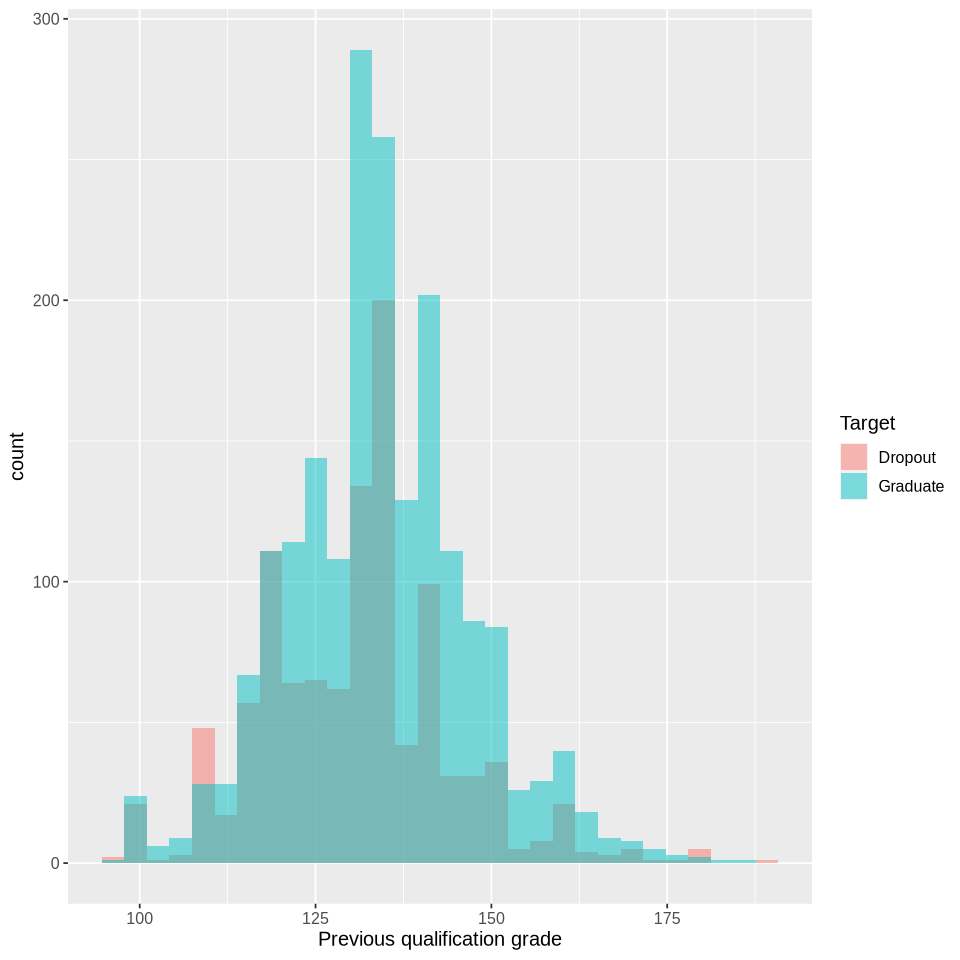

In [4]:
options(repr.plot.width = 8, repr.plot.height = 8)
grade_plot <- tidy_data |>
  ggplot(aes(x = Previous_qualification_grade, fill = Target)) +
  geom_histogram(alpha = 0.5, position = "identity") +
  labs( x = "Previous qualification grade", fill = "Target") +
  theme(text = element_text(size = 12))
grade_plot